In [1]:
import torch
import torch.nn as nn
from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from torchsummary import summary
import torch.nn.functional as F
import scipy as sp

epochs = 200
n_tasks = 5
L = 0
gamma0 = 1
widths = [2048*2]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(1234)
batch = 25
eta = 0.1

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param =='ntk':
                    self.gamma = gam
                    self.in_scale = 784**0.5
                    self.out_scale = self.w**0.5*self.gamma
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                     self.in_scale = 784**0.5
                     self.out_scale = self.w**0.5*self.gamma
                elif param == 'sp':
                     self.gamma = 1
                     self.in_scale = 1
                     self.out_scale = 1

                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.fc2 = nn.Linear(self.w, 1, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                h1 = self.fc1(x)/self.in_scale
                h1act = self.relu(h1)
                #h1act = h1
                z = ( torch.sum(self.fc2.weight.T, dim=1)).detach().clone()
                h2 = self.fc2(h1act)/self.out_scale
            
                return h2, h1.detach().clone(), z

@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()

def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
tasks = []
tasks_test = []
for dig1, dig2 in zip([0],[1]):
    data = pd.read_csv('~/data/MNIST/mnist_train.csv')
    test = pd.read_csv('~/data/MNIST/mnist_test.csv')
    data = data[data['label'].isin([dig1, dig2])]
    test = test[test['label'].isin([dig1, dig2])]
    
    X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
    X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255
    X = X[:batch]
    
    Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
    Y = torch.tensor([[y*1.0-torch.min(Y_temp)] for y in Y_temp], device=device)
    Y = Y[:batch]
    _ , indeces = torch.sort(Y_temp[:batch])
    Y = Y[indeces]
    X = X[indeces]
    
    Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
    Y_test = torch.tensor([[y*1.0- torch.min(Y_temp)] for y in Y_temp], device=device)
    
    tasks.append(X)
    tasks_test.append(X_test)

perc = 1
lim = int((784-int(X.shape[1]*perc))/2)

for _ in range(n_tasks):
        par_perm = np.append(np.append(np.arange(0,lim,1),np.random.permutation(int(X.shape[1]*perc))+lim), np.arange(int(X.shape[1]*perc)+lim,784,1))
        #perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=par_perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=par_perm)).to(device))

In [2]:
def plot_dist(vecs, all= True, log= True):
    fig = plt.figure(figsize=(10,6))
    for vec in vecs:
        counts, bins = torch.histogram(vec.view(-1), bins=200)
        plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])))
        if not all:
            if log:
                plt.yscale('log')
            plt.grid()
            plt.xlabel('x')
            plt.ylabel('p(x)')
            plt.show()
    if all:
        if log:
            plt.yscale('log')
        plt.xlabel('x')
        plt.ylabel('p(x)')
        plt.grid()
        #plt.legend()
        plt.show()

def compare(phi, phi2):
    fig, ax = plt.subplots(1,2)
    a1 = ax[0].imshow(phi, cmap='coolwarm')
    a2 = ax[1].imshow(phi2, cmap='coolwarm')
    plt.colorbar(a1)
    plt.colorbar(a2)
    plt.show()
        
def sampleChi(K, P, S):
    return torch.distributions.MultivariateNormal(torch.zeros(P), K).sample((S,))

# -----------------------------------------------------------------------------------------
def sampleXi(S):
    return torch.distributions.Normal(0,1).sample((S,))

# -----------------------------------------------------------------------------------------
def get_Phi(h1,h2,relu=True):
    if relu:
        h1 = h1 * (h1>0)
        h2 = h2 * (h2>0)
    N = h1.shape[0]
    
    return h1.T @ h2 / N

# -----------------------------------------------------------------------------------------
def get_G(z1, h1,h2, relu=True):
    N = z1.shape[0]
    if relu:
        g1 = torch.stack([z1] * len(X), dim=1) * (h1>0) 
        g2 = torch.stack([z1] * len(X), dim=1) * (h2>0)
    else:
        return z1.T @ z1 / N

    return g1.T @ g2 / N

def Update( delta, zup, hup, z, h, K, gamma0, eta, relu=True):
    P = delta.shape[0]
    if relu:
        g = torch.stack([z] * len(X), dim=1) * (h > 0)
        hact1 = h * (h > 0)
    else:
        g = torch.stack([z] * len(X), dim=1)
        hact1 = h
    
    dh = torch.einsum('ij, kj -> ik' ,torch.einsum('ij, j -> ij', g , delta), K )
    dz = torch.einsum('ij, j -> i', hact1 , delta)
    #dh = g @ (K.T * torch.stack([delta] * len(X), dim=1))
    #dz = hact1 @ delta

    h_up = hup + eta*gamma0/P*dh
    z_up = zup + eta*gamma0/P*dz

    return h_up, z_up

def updateDelta(ht, hc, z, K, delta, deltac, eta):
    
    Phi = get_Phi(ht, hc, relu=relu)
    G = get_G(z, ht, hc, relu=relu)
    ntk = Phi + G * K
    del_new = delta - eta/P * ntk @ deltac
        
    return del_new

def compare_NTK(idxs):
    for idx in idxs:
        Phi_exp = h2[idx] @ h[idx].T/N
        G_exp = g2[idx] @ g[idx].T/N
        Phi_th = Phis2[idx]
        G_th = Gs2[idx]
        ntk_exp = (Phi_exp + G_exp*K_x.to(device)).cpu()
        ntk_th = (Phi_th.to(device) + G_th.to(device)*K_x.to(device)).cpu()
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].set_title('Expr')
        ax[1].set_title('Theory')
        exp = ax[0].imshow(ntk_exp.cpu(), cmap='coolwarm')
        th = ax[1].imshow(ntk_th.cpu(), cmap='coolwarm')
        plt.colorbar(exp)
        plt.colorbar(th)
        plt.show()

def plotKernel(idx,idx2, time, relu=True):

        Phi_exp = get_Phi(h[idx,time],h[idx2,time], relu)
        G_exp = get_G(z[0, time], h[idx, time], h[idx2, time], relu)

        Phi0 = get_Phi(hs[idx, 0],hs[idx2, 0], relu)
        G0 = get_G(zs[0, 0],hs[idx, 0],hs[idx2, 0], relu)
        PhiT = get_Phi(hs[idx, time],hs[idx2, time], relu)
        GT = get_G(zs[0, time],hs[idx, time],hs[idx2, time], relu)

        fig, ax = plt.subplots(3,4, figsize=(15,8))

        ax1 = ax[0,0].imshow(Ks[idx,idx2].cpu(), cmap='coolwarm')
        ax[0,0].set_title('$K^x$')

        ax2 = ax[0,1].imshow(Phi0, cmap='coolwarm')
        ax[0,1].set_title('$\Phi^1(0)$')

        ax3 = ax[0,2].imshow(G0, cmap='coolwarm')
        ax[0,2].set_title('$G^1(0)$')

        ax4 = ax[0,3].imshow(Phi0 + G0 * Ks[idx,idx2].cpu(), cmap='coolwarm')
        ax[0,3].set_title('$\Theta^1(0)$')

        ax5 = ax[1,0].imshow(Ks[idx,idx2].cpu(), cmap='coolwarm')
        ax[1,0].set_title('$K^x$')

        ax6 = ax[1,1].imshow(PhiT, cmap='coolwarm')
        ax[1,1].set_title('$\Phi^1(\infty)$')

        ax7 = ax[1,2].imshow(GT, cmap='coolwarm')
        ax[1,2].set_title('$G^1(\infty)$')

        ax8 = ax[1,3].imshow(PhiT + GT * Ks[idx,idx2].cpu(), cmap='coolwarm')
        ax[1,3].set_title('$\Theta(\infty)$')

        ax9 = ax[2,0].imshow(Ks[idx,idx2].cpu(), cmap='coolwarm')
        ax[2,0].set_title('$K^x$')

        ax10 = ax[2,1].imshow(Phi_exp.cpu(), cmap='coolwarm')
        ax[2,1].set_title('$\Phi^1(\infty)_{Exper}$')

        ax11 = ax[2,2].imshow(G_exp.cpu(), cmap='coolwarm')
        ax[2,2].set_title('$G^1(\infty)_{Exper}$')

        ax12 = ax[2,3].imshow(Phi_exp.cpu() + G_exp.cpu() * Ks[idx,idx2].cpu(), cmap='coolwarm')
        ax[2,3].set_title('$\Theta(\infty)_{Exper}$')

        axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
        for i,a in enumerate(axes):
            plt.colorbar(a, ax=ax[int(i/4), i%4])
        
        plt.tight_layout()
        plt.show()

def computeCorr(h1,h2,z,typekern):
    if typekern == 'h':
        kernels = torch.einsum('ijkl, ijkd -> ijld', h1*(h1>0)/S, h2*(h2>0))
    elif typekern == 'g':
        kernels = torch.einsum('ijkl, ijkd -> ijld', torch.stack([z] * len(X), dim=3)*(h1>0)/S, torch.stack([z] * len(X), dim=3)*(h2>0))
    norms = torch.norm(kernels, dim=(2, 3))
    norm = torch.einsum('ij,ik -> ijk', norms, norms)
    corr = torch.einsum('ijkl, iakl -> ija', kernels, kernels) / norm
    
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    for i in range(2):
        for j in range(3):
            a = ax[i,j].imshow(corr[3*i+j], cmap='coolwarm')
            ax[i,j].invert_yaxis()
            plt.colorbar(a, ax=ax[i,j])
            for d in range(n_tasks+1):
                ax[i,j].axvline(d*epochs, color='black', alpha=0.7, linestyle=':')
                ax[i,j].axhline(d*epochs, color='black', alpha=0.7, linestyle=':')
    fig.suptitle('Time correlation of Kernels during training', fontsize=16)        
    plt.show()
    

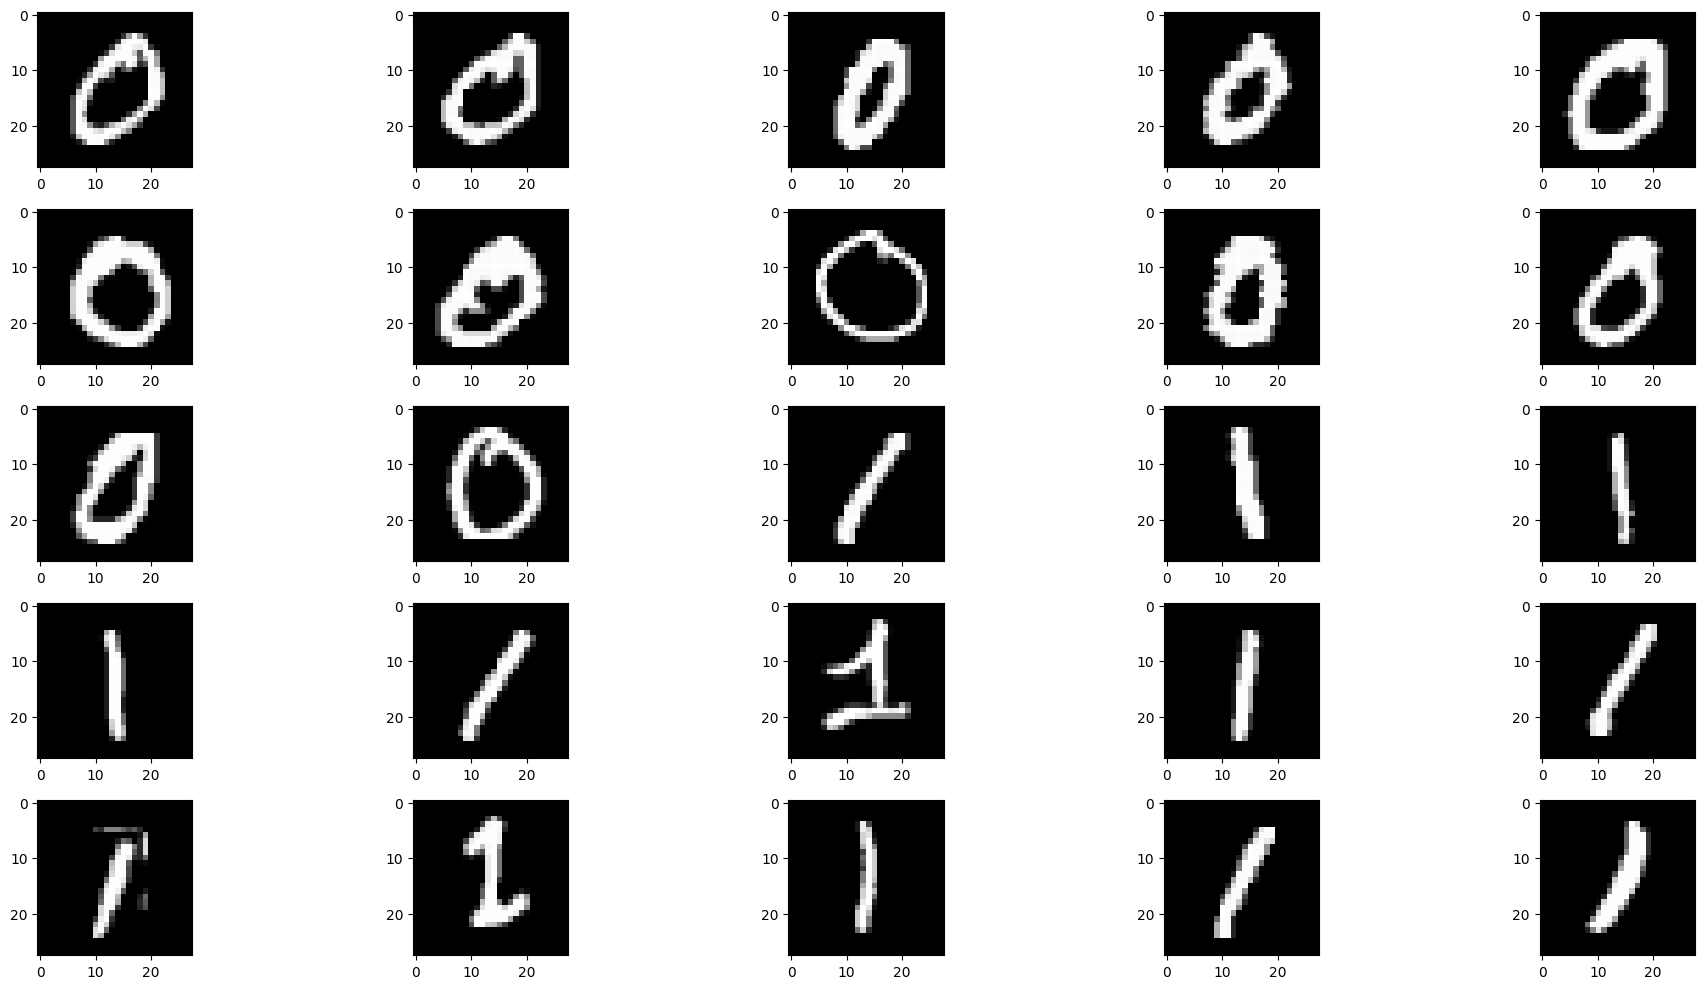

In [3]:
fig, ax = plt.subplots(5,5, figsize=(20,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(tasks[0][i*5+j].view(28,28).cpu(), cmap='gray')

plt.tight_layout()

In [4]:
save_out = False
D = X.shape[1]
P = len(X)

for regime in ['mup']:
    for N in widths:
        
        h = torch.empty((n_tasks+1,(n_tasks+1)*epochs, N, P))
        z = torch.empty((1,(n_tasks+1)*epochs, N))
        loss = torch.empty((n_tasks+1, (n_tasks+1)*epochs))

        acc = []    
        
        mlp = MLP(N,L,regime, gamma0)
        lrs = {'sp':1,'ntk':1,'mup': eta*mlp.gamma**2}
        lr = lrs.get(regime)

        if regime == 'ntk' or regime == 'mup':
            mlp = mlp.apply(init_weights)
            
        #summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr= lr )
        eos = 2/lr
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):

                            running_loss = 0.0
                            
                            for n,X in enumerate(tasks):
                                out, ht, zt = mlp(X)
                                h[n,t*epochs+epoch] = ht.T
                                z[0,t*epochs+epoch] = zt.T
                                loss[n,t*epochs+epoch] = MSE(out,Y)*0.5
                            
                            optimizer.zero_grad()

                            out, _ , _ = mlp(Xt)
                            losscurr = MSE(out, Y)*0.5
                           
                            losscurr.backward()
                           
                            running_loss += losscurr.item()
                            
                            optimizer.step()

                print(f'Finished Training task{t}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.round(mlp(tasks_test[s])[0]) == Y_test)/len(Y_test)).item() )  
                acc.append(acct) 
                
        if save_out:        
            torch.save(loss, f'loss_data/loss{N}_gamma{gamma0}.pt')
        


/var/folders/bf/nxgsxk9n0xvdy1w25bwdrpg80000gn/T/ipykernel_38417/847194923.py:37: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3639.)
  z[0,t*epochs+epoch] = zt.T


Finished Training task0, train loss: 0.0024475474655628205
Finished Training task1, train loss: 0.000765957161784172
Finished Training task2, train loss: 0.000381060391664505
Finished Training task3, train loss: 0.0002390136756002903
Finished Training task4, train loss: 0.00033129192888736725
Finished Training task5, train loss: 0.00019461996853351594


In [5]:
mlp = mlp.eval()

In [6]:
(torch.sum(torch.round(mlp(X_test)[0]) == Y_test)/len(Y_test)).item()

0.6278960108757019

In [7]:
(torch.sum(torch.round(mlp(tasks_test[1])[0]) == Y_test)/len(Y_test)).item()

0.909692645072937

In [8]:
D = X.shape[1]
N = widths[-1]
P = len(X)

In [9]:
Ks = torch.empty((n_tasks+1, n_tasks+1, P, P))
for i in range(n_tasks+1):
    for j in range(n_tasks+1):
       Ks[i,j] = tasks[i] @ tasks[j].T / D

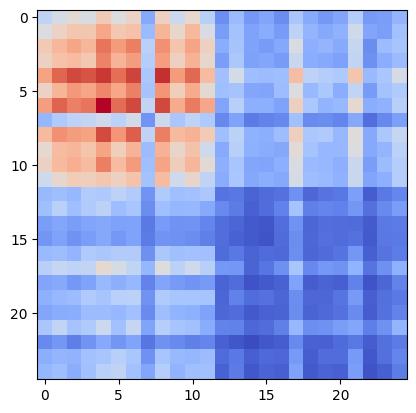

In [10]:
plt.imshow(Ks[0,1], cmap='coolwarm')
plt.show()

In [11]:
S = 10000
relu = True

hs = torch.empty((n_tasks+1,(n_tasks+1)*epochs+1, S, P))
zs = torch.empty((1,(n_tasks+1)*epochs+1, S))
deltas = torch.empty((n_tasks+1,(n_tasks+1)*epochs+1, P))

zs[0,0] = sampleXi(S)

for t in range(n_tasks+1):
    hs[t,0] = sampleChi(Ks[t,t], P, S)
    deltas[t,0] = torch.sum(Y, dim=1).cpu()

for c in range(n_tasks+1):
    for i in np.arange(c*epochs,(c+1)*epochs,1):
        for t in range(n_tasks+1):
            
            h_up, z_up = Update( deltas[c,i] , zs[0,i], hs[t,i], zs[0,i], hs[c,i], Ks[t,c], gamma0, eta, relu=relu)
            hs[t,i+1] = h_up
            zs[0,i+1] = z_up

            delta_up = updateDelta( hs[t,i], hs[c,i], zs[0,i], Ks[t,c], deltas[t,i], deltas[c,i], eta )
            deltas[t,i+1] = delta_up


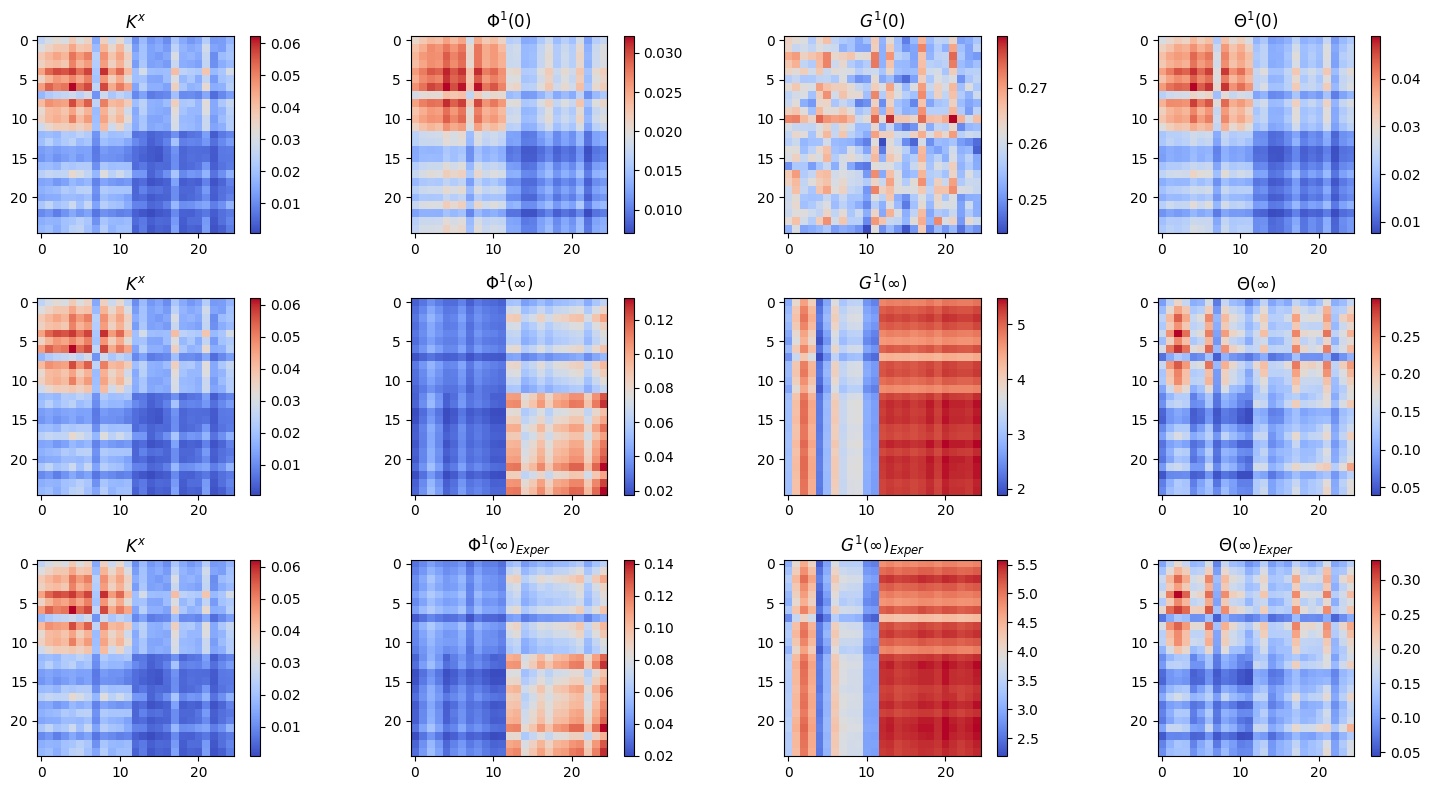

In [12]:
plotKernel(0,1,2*epochs)

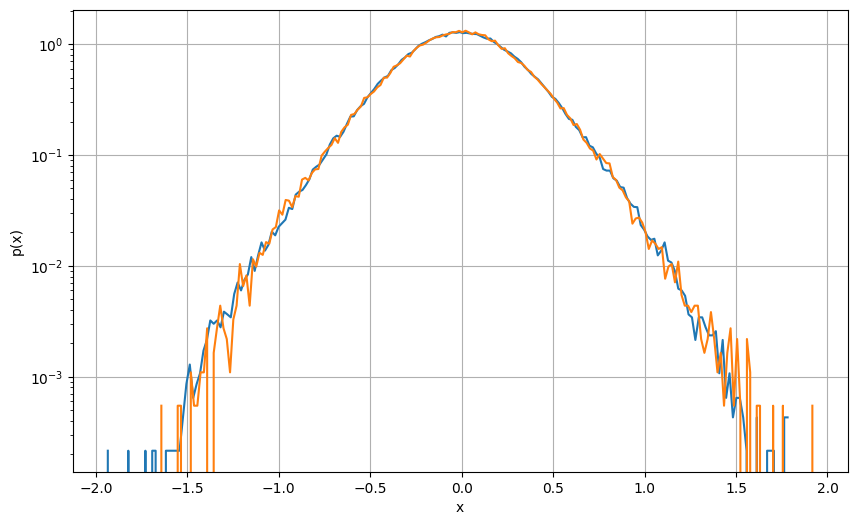

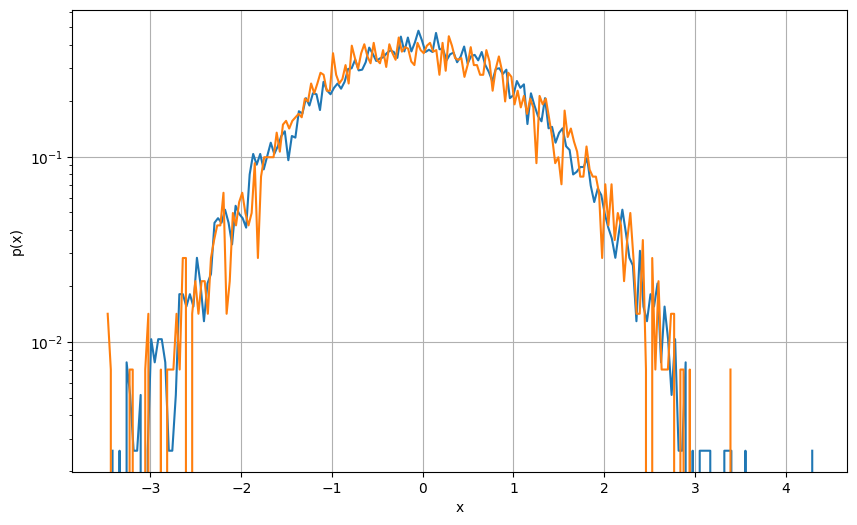

In [13]:
q = 2
plot_dist([hs[0,q], h[0,q]],)
plot_dist([zs[0,q], z[0,q]],)

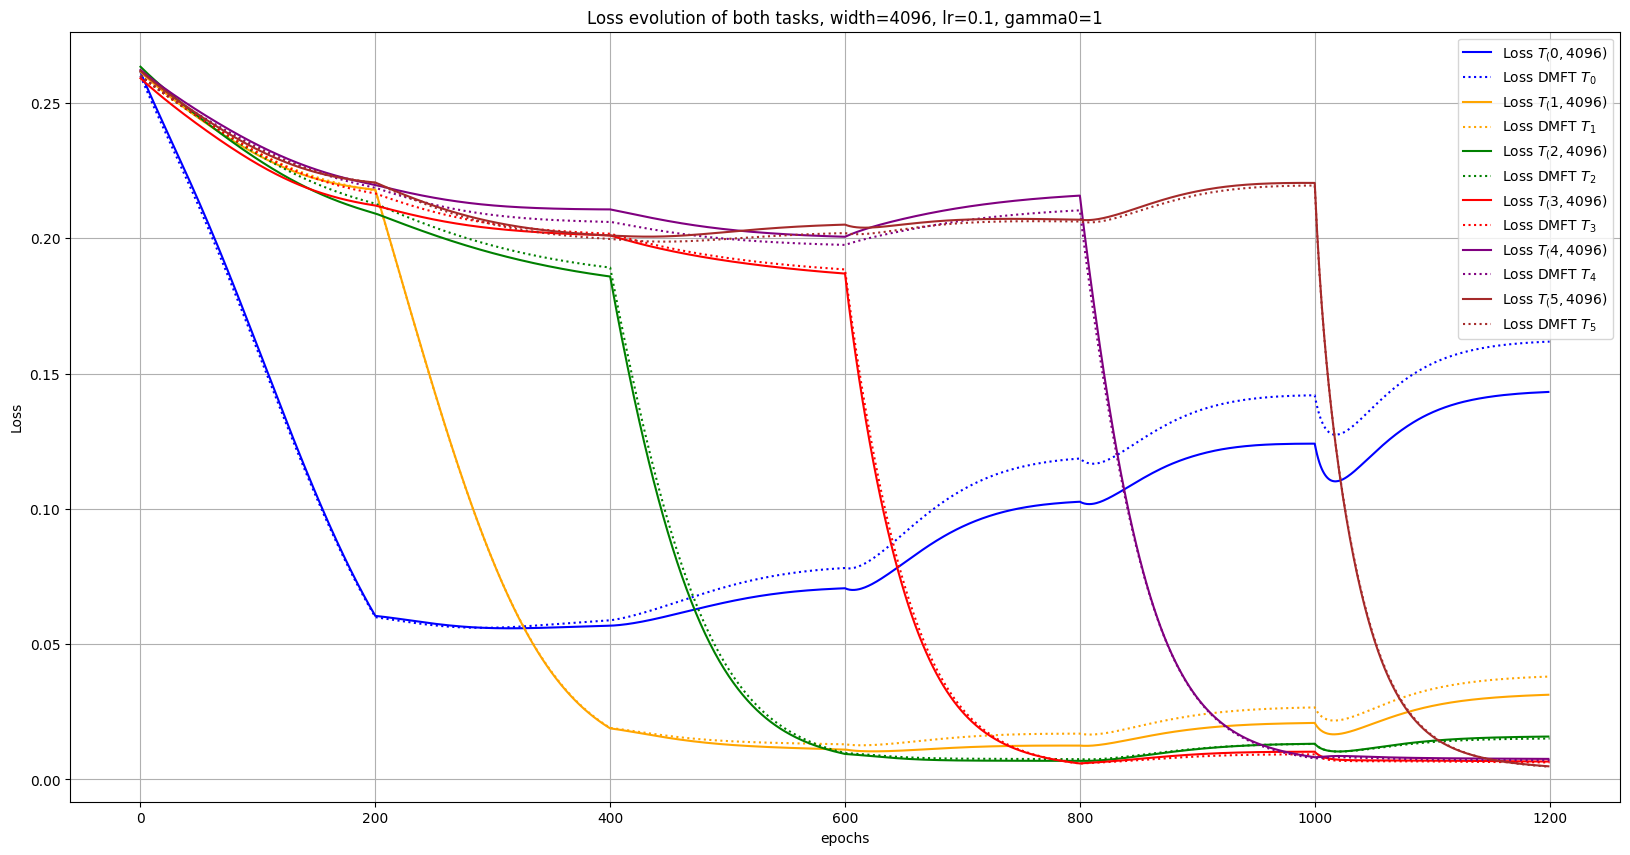

In [14]:
colors = ['blue', 'orange','green','red','purple','brown','pink', 'gray', 'olive', 'cyan' , 'darkgreen']

fig = plt.figure(figsize=(20,10))
for i in range(n_tasks+1):
        #loss = torch.load(f'/Users/alessandrobreccia/Desktop/THESIS/loss_data/loss{N}_gamma{gamma0}.pt')
        plt.plot(loss[i].detach().numpy(), alpha= 1, label=f'Loss $T_{i,N}$', color=colors[i])
        plt.plot(torch.mean(deltas[i]**2, axis =1)/2, linestyle=':', color=colors[i], label=f'Loss DMFT $T_{i}$')
        #plt.fill_between(np.arange(0,(n_tasks+1)*epochs+1,1),torch.mean(deltas[i]**2, axis =1)/2-(1/N*P)**2*np.arange(0,(n_tasks+1)*epochs+1,1), torch.mean(deltas[i]**2, axis =1)/2+(1/N*P)**2*np.arange(0,(n_tasks+1)*epochs+1,1), alpha=0.05, color=colors[i])

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
#plt.axvline(epochs, color='darkgreen', linestyle='-', alpha = 0.3)
plt.grid()
plt.title(f'Loss evolution of both tasks, width={N}, lr={eta}, gamma0={gamma0}')
plt.show()


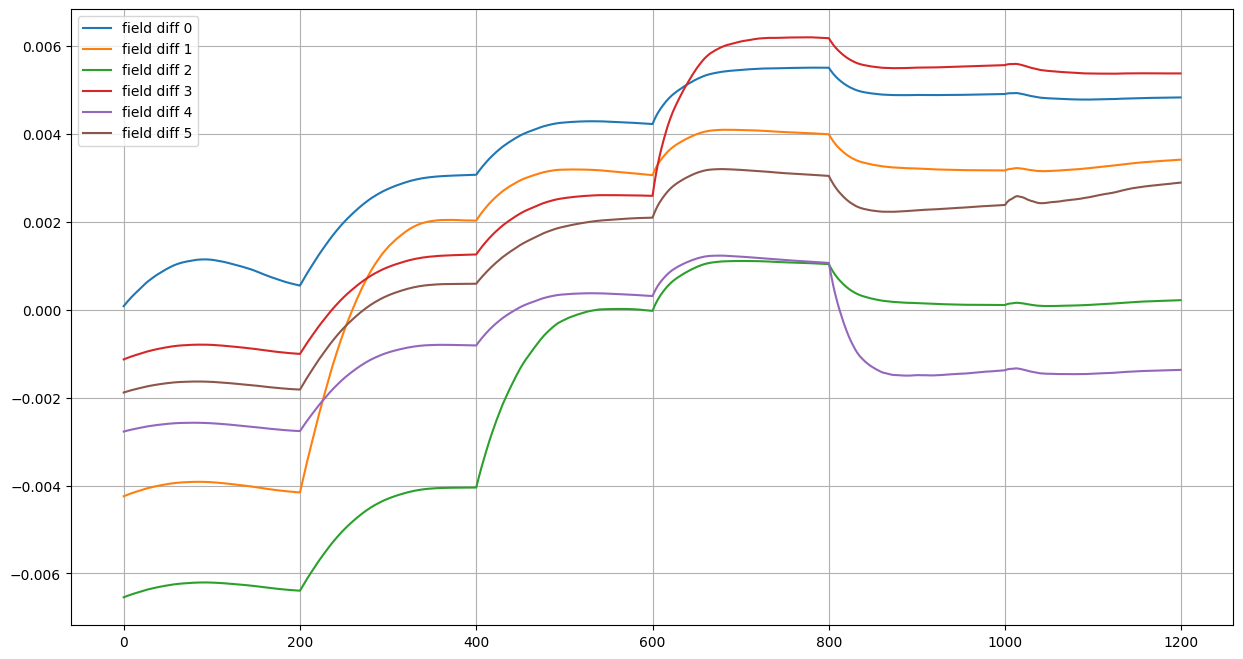

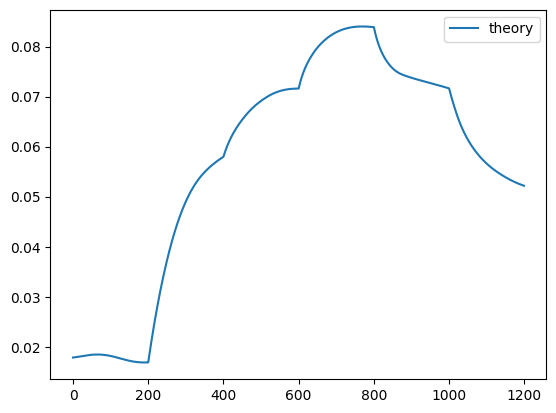

In [15]:
fig = plt.figure(figsize=(15,8))
for i in np.arange(0,n_tasks+1,1):
    plt.plot(torch.mean(hs[i,:-1], axis = [1,2]) - torch.mean(h[i].cpu(), axis = [1,2]), label=f'field diff {i}')
plt.grid()
plt.legend()
plt.show()

plt.plot(torch.mean(zs[0,:-1], axis = [1])-torch.mean(z[0,:], axis = [1]), label='theory')
#plt.plot(torch.mean(z[0,:], axis = [1]), label='exp')
plt.legend()
plt.show()

In [16]:
HLT

NameError: name 'HLT' is not defined

In [ ]:
computeCorr(hs,hs,zs,'g')
computeCorr(h,h,z,'g')

In [ ]:
computeCorr(hs,hs,zs,'h')
computeCorr(h,h,z,'h')

In [ ]:
from kmeans_pytorch import kmeans, kmeans_predict

In [ ]:
space = 100
feat_scoret = torch.empty((n_tasks+1,space))
feat_scoree = torch.empty((n_tasks+1,space))

for t in range(n_tasks+1): 
    for j in range(space):
        
        cluster_ids_x, cluster_centers = kmeans( X=h[t,int(n_tasks*epochs/space*j)].T, num_clusters=2, distance='euclidean', device=device)
    
        if cluster_ids_x[0].item() == 1:
            feat_scoree[t,j] = torch.sum(((cluster_ids_x-1)*-1 - Y.view(-1).cpu())**2)/2
        else:
            feat_scoree[t,j] = torch.sum((cluster_ids_x - Y.view(-1).cpu())**2)/2

for t in range(n_tasks+1): 
    for j in range(space):
        
        cluster_ids_x, cluster_centers = kmeans( X=hs[t,int(n_tasks*epochs/space*j)].T, num_clusters=2, distance='euclidean', device=device)
    
        if cluster_ids_x[0].item() == 1:
            feat_scoret[t,j] = torch.sum(((cluster_ids_x-1)*-1 - Y.view(-1).cpu())**2)/2
        else:
            feat_scoret[t,j] = torch.sum((cluster_ids_x - Y.view(-1).cpu())**2)/2

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20,8))
for t in range(n_tasks+1):
    ax[int(t/3),t%3].plot(np.linspace(0,epochs*(n_tasks+1),space),feat_scoree[t]/P, color = 'blue', alpha = 0.5, label = 'exp')
    ax[int(t/3),t%3].plot(np.linspace(0,epochs*(n_tasks+1),space),feat_scoret[t]/P, color = 'red', alpha = 0.5, label = 'theory')
    ax[int(t/3),t%3].axvline((t+1)*epochs, color='black', linestyle='-.')
    ax[int(t/3),t%3].legend(prop={'size':13})
    ax[int(t/3),t%3].axvline((t)*epochs, color='black', linestyle='-.')
    ax[int(t/3),t%3].set_title(f'Error on Kmeans clusters, task {t}')

In [ ]:
!tar chvfz DMFTserial.tar.gz datatot loss_data DMFT.ipynb MUP.ipynb NTK2.ipynb